# Q-LEARNING 알고리즘을 쥐 월드와 함께 구현!

## ATARI GAME DOMAIN 에서 인간보다 뛰어난 실력을 보여주었던, DQN 알고리즘의 시초!
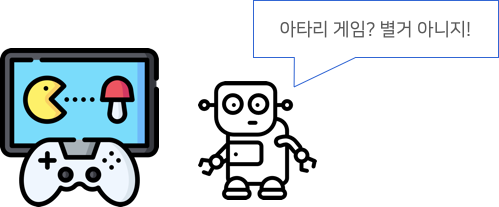

# 실습에 필요한 도구
## 1번 도구: 쥐가 상호작용 할 수 있는 시뮬레이션 환경 (미리 구현)

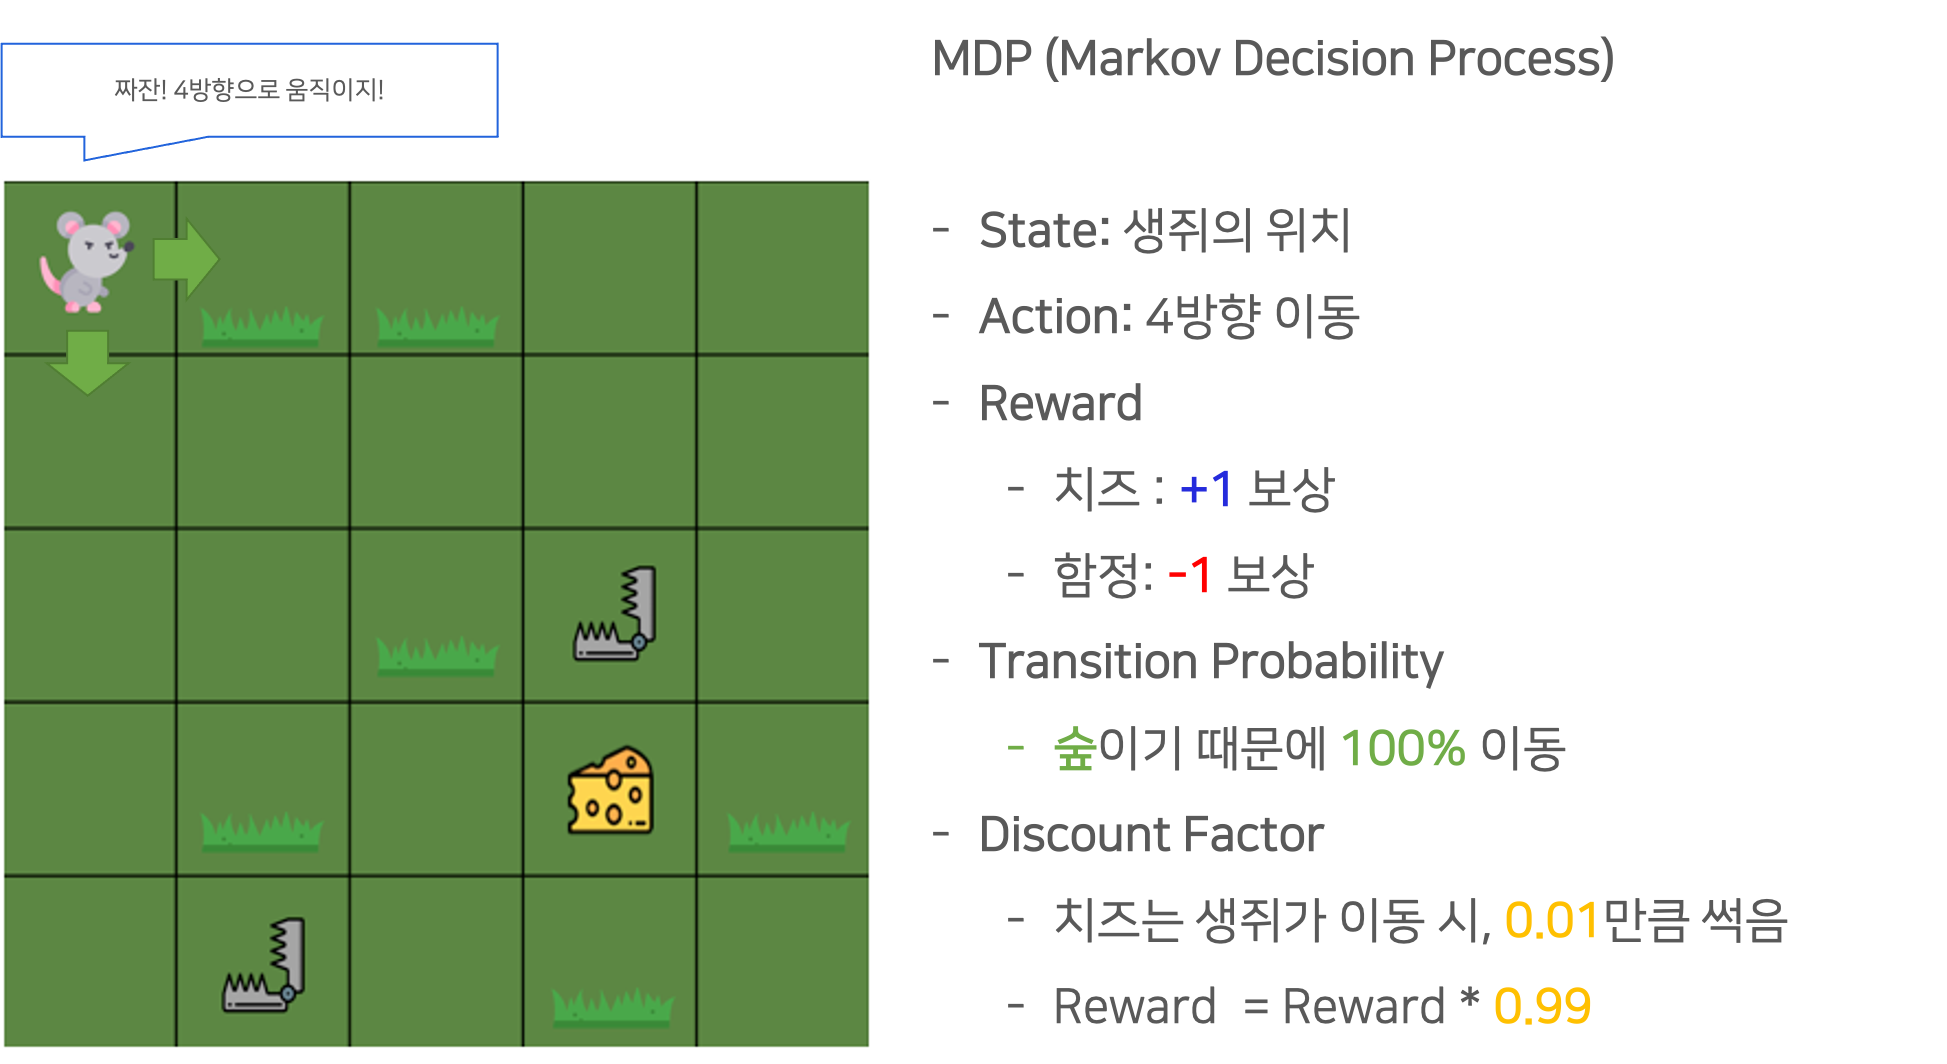

## 2번 도구: Q 값들을 저장할 공간 (Q-Table)

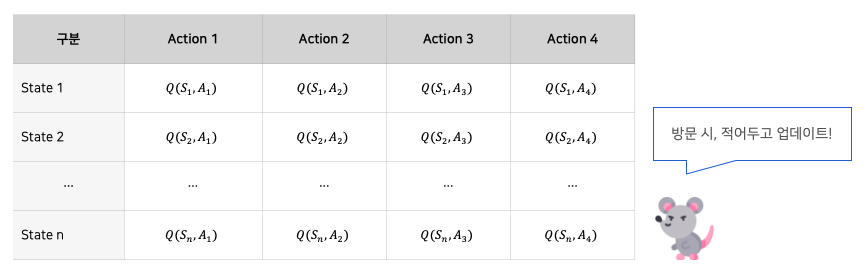

## 3번 도구: Q-LEARNING 알고리즘

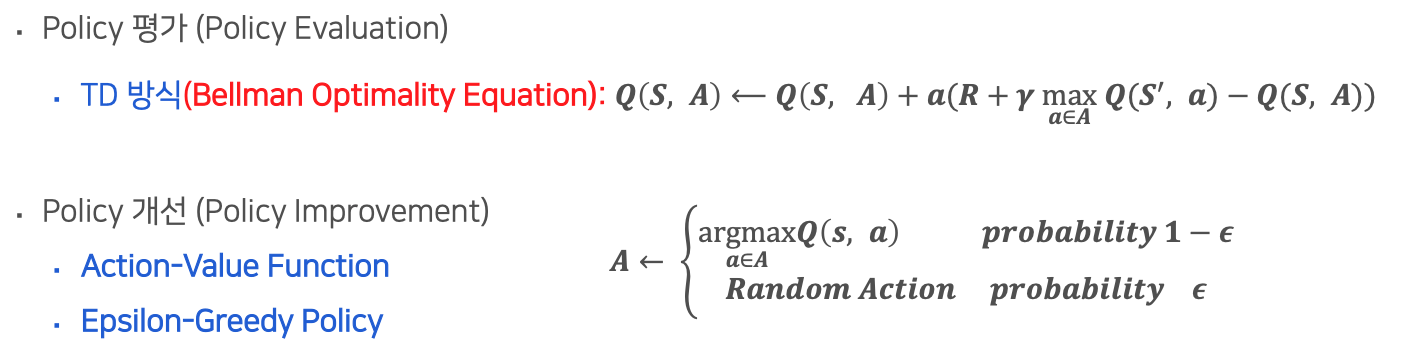

## Table 구성, Policy 평가 및 개선

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(12345)
np.random.seed(12345)

# Q TABLE
class QTable():
    def __init__(self, num_actions, learning_rate, discount_factor, epsilon_greedy):
        self.q_table = dict()         # Q table
        self.actions = num_actions    # Action 수        = 좌, 우, 상, 하 (4방향)
        self.lr = learning_rate       # Learning Rate   = 학습 속도
        self.gamma = discount_factor  # Discount Factor = 치즈가 썪는 속도
        self.epsilon = epsilon_greedy # Epsilon factor  = 탐험을 얼마나 하는가

    # 정책 평가 (Policy Evaluation)
    # Temporal-Dffierence 방법 (Bellman Expectation Equation)
    # 1 step 진행 결과 사용, Q_table 업데이트
    def policy_evaluation(self, s, a, r, s_, done):
        s = str(s)
        s_ = str(s_)
        temp_q_pred = self.q_table[s][a]

        # 𝑸(𝑺,𝑨) ⟵ 𝑸(𝑺,𝑨)+ 𝒂(𝑹 + 𝜸𝑸(𝑺′, 𝑨′) − 𝑸(𝑺, 𝑨)) => SARSA
        # 𝑸(𝑺,𝑨) ⟵ 𝑸(𝑺,𝑨)+ 𝒂(𝑹 + 𝜸 max 𝑸(𝑺′, a) − 𝑸(𝑺, 𝑨)) => !!!!!SARSA와 다른점!!!!!
        if not done:
            temp_q_target = r + self.gamma * np.max(self.q_table[s_])
        else:
            temp_q_target = r

        self.q_table[s][a] += self.lr * (temp_q_target - temp_q_pred)

    # 정책 개선 (Policy Improvement)
    # Action-Value Function
    # Epsilon-Greedy Policy
    def choose_action(self, observation, next_action=False):
        observation = str(observation)

        if observation in self.q_table:
            pass
        else:
            self.q_table[observation] = [0] * self.actions

        # next_action은 Q-Learning에서 할 필요가 없음
        if next_action == True:
            return None

        # Epsilon-Greedy
        # state_action: Q_table에 있는 Q(S,1), Q(S,2), Q(S,3), Q(S,4)
        # state_action 값 중, MAX 값을 찾음
        # 단, 같은 action-value function의 값이 있는 경우, 랜덤으로 선택
        if np.random.rand() > self.epsilon:
            state_action = self.q_table[observation]
            actions = (state_action == np.max(state_action))
            selected_action = np.random.choice([i for i in range(len(actions))\
                                                if actions[i] == True])
        else:
            # Epsilon 보다 값이 작으면 Random으로 선택
            selected_action = np.random.choice(self.actions)

        self.epsilon = self.epsilon - 1e-3

        return selected_action


## 실제 동작시켜봅시다!

5회 진행하면서 받은 총 Reward는 1 입니다.
5회 진행하면서 받은 총 Reward는 5 입니다.
5회 진행하면서 받은 총 Reward는 5 입니다.
5회 진행하면서 받은 총 Reward는 5 입니다.
5회 진행하면서 받은 총 Reward는 5 입니다.
5회 진행하면서 받은 총 Reward는 5 입니다.


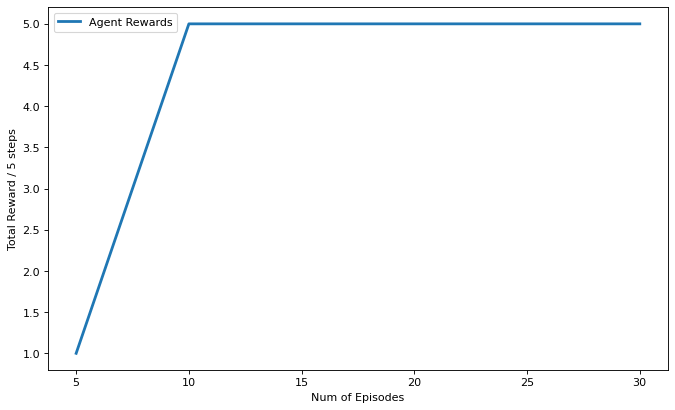

In [6]:
import matplotlib.pyplot as plt
from mouse_cage import MouseWorld

# 간단한 reward 그래프
def cumulated_reward_graph(x_axis_data, data):
    plt.figure(figsize=(10, 6), dpi=80)
    plt.xlabel('Num of Episodes')
    plt.ylabel('Total Reward / 5 steps')
    plt.plot(x_axis_data, data, linewidth=2.5, linestyle="-", label="Agent Rewards")
    plt.legend()
    plt.show()


# 실제 업데이트
def update(env, RL):
    x_axis_data = []      # 그래프 X 축
    total_reward = []     # 전체 Reward
    temp_reward = 0       # Episode 1회 동안 받은 Reward
    total_epi = 30        # 전체 Episode 수
    num_epi = 0           # 현재 Episode 차례
    save_reward = 5       # 몇 회 Reward의 합을 그래프에 표시
    max_visit_count = 99  # 게임이 끝나지 않을 경우, 끝내기 위한 수

    # 에피소드 시작
    for _ in range(total_epi):
        num_epi += 1

        # 환경 리셋
        observation = env.reset()
        present_visit_count = 0

        while True:
            present_visit_count += 1
            if present_visit_count >= max_visit_count:
                num_epi -= 1
                break

            env.render()

            # 현재 state에서 action 값 받기 (SARSA와 다른점 => SARSA는 while loop 바깥에 있어야함)
            action = RL.choose_action(observation)

            # 선택된 action에 따라서, 쥐를 이동시킴 (S_, R)
            observation_, reward, done = env.step(action)

            # Learn을 위해서는 S, A, R, NEXT_STATE
            # next_action = True (!!!!!SARSA와 다른점!!!!! => action을 취하지 않음, 빈 테이블 값 만들기용)
            action_ = RL.choose_action(observation_, next_action=True)

            # Policy Evaluation 진행
            RL.policy_evaluation(observation, action, reward, observation_, done)

            # State 업데이트 (!!!!!SARSA와 다른점!!!!! => Action 업데이트 하지 않음)
            observation = observation_
            temp_reward += reward

            # 게임이 끝나면 while문 끝냄
            # 에피소드가 5번 진행될 때 마다 reward를 합산해서 보여줌
            if done:
                if num_epi % save_reward == 0:
                    x_axis_data.append(num_epi)
                    total_reward.append(temp_reward)
                    print("5회 진행하면서 받은 총 Reward는 {} 입니다.".format(temp_reward))
                    temp_reward = 0
                break

    # 총 횟수가 끝나면 그래프를 그려줌
    cumulated_reward_graph(x_axis_data, total_reward)
    return total_reward

if __name__ == "__main__":
    ENV = MouseWorld()
    RL = QTable(num_actions=ENV.num_actions, learning_rate=0.01\
                    , discount_factor=0.99, epsilon_greedy=0.2)

    update(ENV, RL)
    ENV.window.mainloop()
